In [1]:
import warnings
import scanpy as sc
import squidpy as sq
import anndata as an
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from urllib import request
import scanorama
import json
import os

sc.settings.set_figure_params(dpi=80)
#sc.set_figure_params(facecolor="white", figsize=(8, 8))
warnings.simplefilter(action='ignore', category=FutureWarning)
sc.settings.verbosity = 3

# Глобальное окружение

## Подгрузим данные

In [2]:
os.listdir('./results/spatial_transcriptomics')

['chimp.h5ad', 'human.h5ad', 'macaque.h5ad']

In [3]:
human = sc.read_h5ad('results/spatial_transcriptomics/human.h5ad')
human.obs_names_make_unique()
human

C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 17633 × 19966
    obs: 'in_tissue', 'array_row', 'array_col', 'label', 'sample_id'
    var: 'gene_ids', 'feature_types'
    uns: 'spatial'
    obsm: 'spatial'

In [4]:
chimp = sc.read_h5ad('results/spatial_transcriptomics/chimp.h5ad')
chimp.obs_names_make_unique()
chimp

C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 22088 × 25080
    obs: 'in_tissue', 'array_row', 'array_col', 'label', 'sample_id'
    var: 'gene_ids', 'feature_types'
    uns: 'spatial'
    obsm: 'spatial'

In [5]:
macaque = sc.read_h5ad('results/spatial_transcriptomics/macaque.h5ad')
macaque.obs_names_make_unique()
macaque

C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 14621 × 21591
    obs: 'in_tissue', 'array_row', 'array_col', 'label', 'sample_id'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

## Глобальные переменные

Найдём общие гены

In [7]:
common_genes = human.var_names & macaque.var_names & chimp.var_names
common_genes

Index(['SAMD11', 'NOC2L', 'KLHL17', 'PLEKHN1', 'PERM1', 'HES4', 'AGRN',
       'RNF223', 'TTLL10', 'TNFRSF18',
       ...
       'PCBP3', 'COL6A2', 'SPATC1L', 'LSS', 'MCM3AP', 'YBEY', 'PCNT', 'DIP2A',
       'S100B', 'PRMT2'],
      dtype='object', length=15585)

Конкатенируем данные

In [8]:
adata = an.concat( [human[human.obs_names, common_genes],
                    macaque[macaque.obs_names, common_genes],
                    chimp[chimp.obs_names, common_genes]],
                    merge='same',uns_merge="unique")
adata

C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 54372 × 15585
    obs: 'in_tissue', 'array_row', 'array_col', 'label', 'sample_id'
    var: 'feature_types'
    uns: 'spatial'
    obsm: 'spatial'

Оставим только размеченные

In [9]:
adata = adata[adata.obs.label.notna()]
adata

View of AnnData object with n_obs × n_vars = 42010 × 15585
    obs: 'in_tissue', 'array_row', 'array_col', 'label', 'sample_id'
    var: 'feature_types'
    uns: 'spatial'
    obsm: 'spatial'

# Diffexpr

## Human

In [4]:
remove = human.var_names.str.startswith('MT-')
keep = np.invert(remove)
print(sum(remove))

human = human[:,keep]

13


In [5]:
human_labeled_nonempty = human[(human.obs.label.notna()) & (human.obs.label != 'Empty spots')].copy()

In [6]:
sc.pp.normalize_total(human_labeled_nonempty, target_sum=1e4)
sc.pp.log1p(human_labeled_nonempty)

normalizing counts per cell
    finished (0:00:00)


In [7]:
human_labeled_nonempty.obs['clusters'] = human_labeled_nonempty.obs.label
human_labeled_nonempty.obs.clusters.replace({'L6a': 'L6', 'L6b': 'L6'}, inplace=True)

In [8]:
sc.tl.rank_genes_groups(human_labeled_nonempty, groupby='clusters', method='wilcoxon')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:01:17)


         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:02:16)
Storing dendrogram info using `.uns['dendrogram_clusters']`


C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


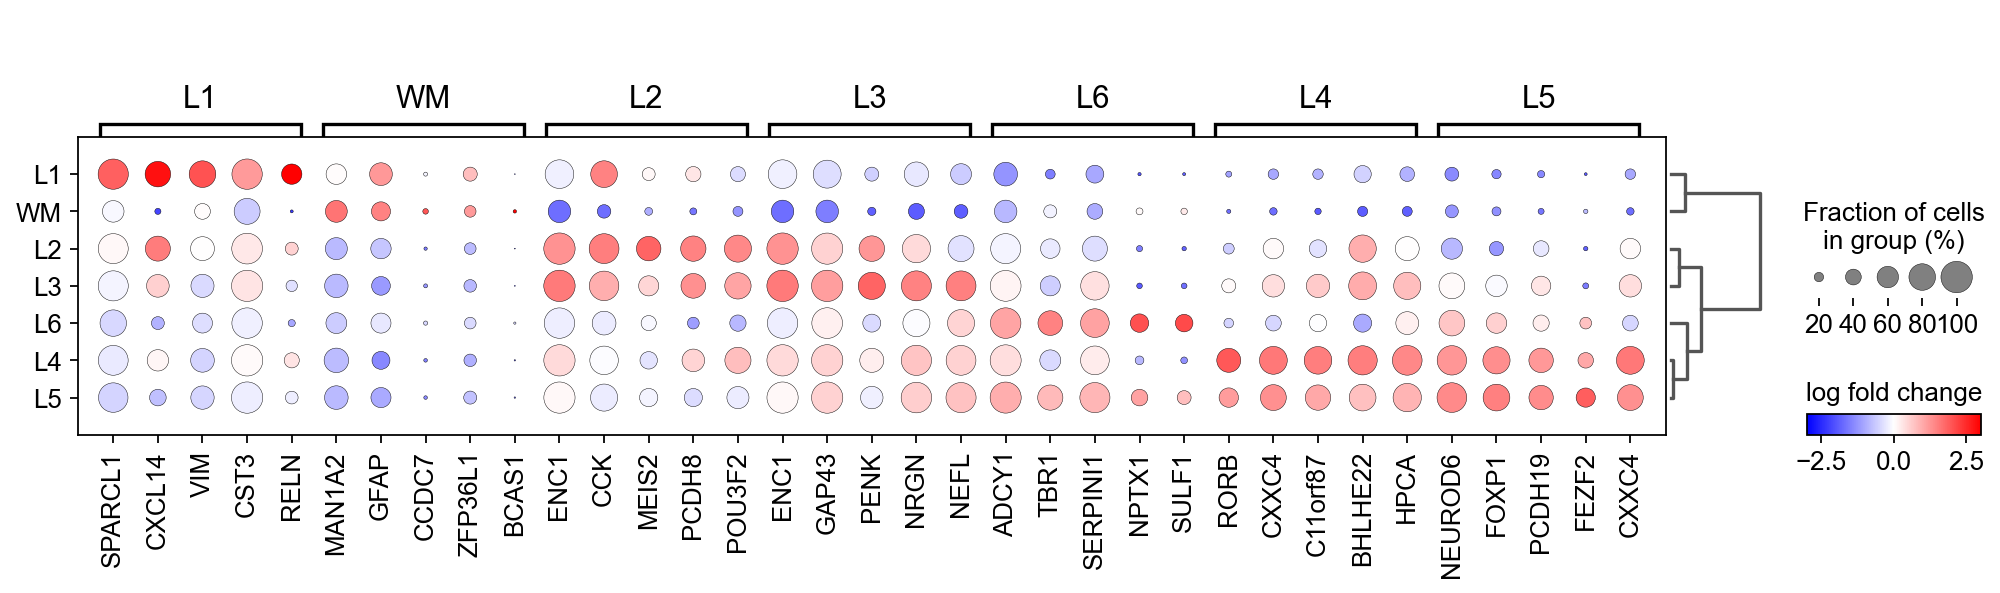

In [9]:
sc.pl.rank_genes_groups_dotplot(human_labeled_nonempty, n_genes=5, groupby="clusters", values_to_plot='logfoldchanges',
                                min_logfoldchange=1, vmax=3, vmin=-3, cmap='bwr')

C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


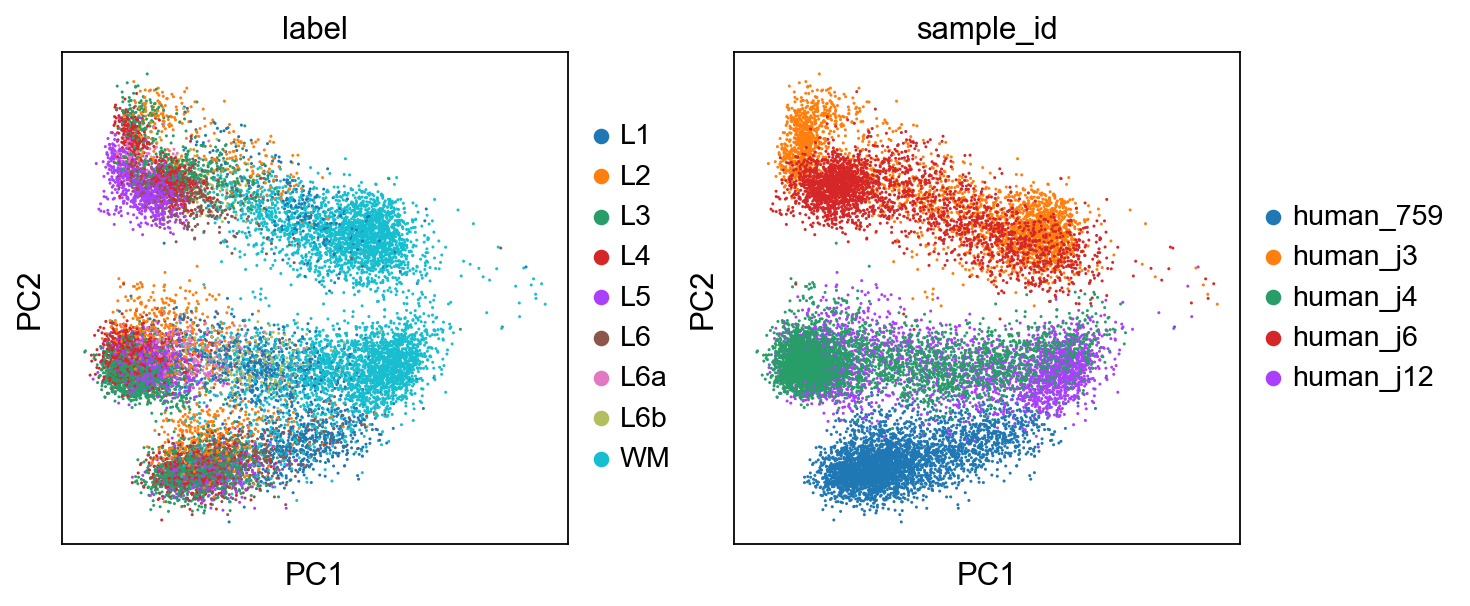

In [10]:
sc.pl.pca(human_labeled_nonempty, color=['label', 'sample_id'])

## Chimp

In [6]:
remove = chimp.var_names.str.startswith('MT-')
keep = np.invert(remove)
print(sum(remove))

chimp = chimp[:,keep]

13


In [7]:
chimp_labeled_nonempty = chimp[(chimp.obs.label.notna()) & (chimp.obs.label != 'Empty spots')].copy()

In [8]:
sc.pp.normalize_total(chimp_labeled_nonempty, target_sum=1e4)
sc.pp.log1p(chimp_labeled_nonempty)

normalizing counts per cell
    finished (0:00:00)


In [9]:
chimp_labeled_nonempty.obs['clusters'] = chimp_labeled_nonempty.obs.label
chimp_labeled_nonempty.obs.clusters.replace({'L6a': 'L6', 'L6b': 'L6'}, inplace=True)

In [10]:
sc.tl.rank_genes_groups(chimp_labeled_nonempty, groupby='clusters', method='wilcoxon')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:01:57)


         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:01:47)
Storing dendrogram info using `.uns['dendrogram_clusters']`


C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


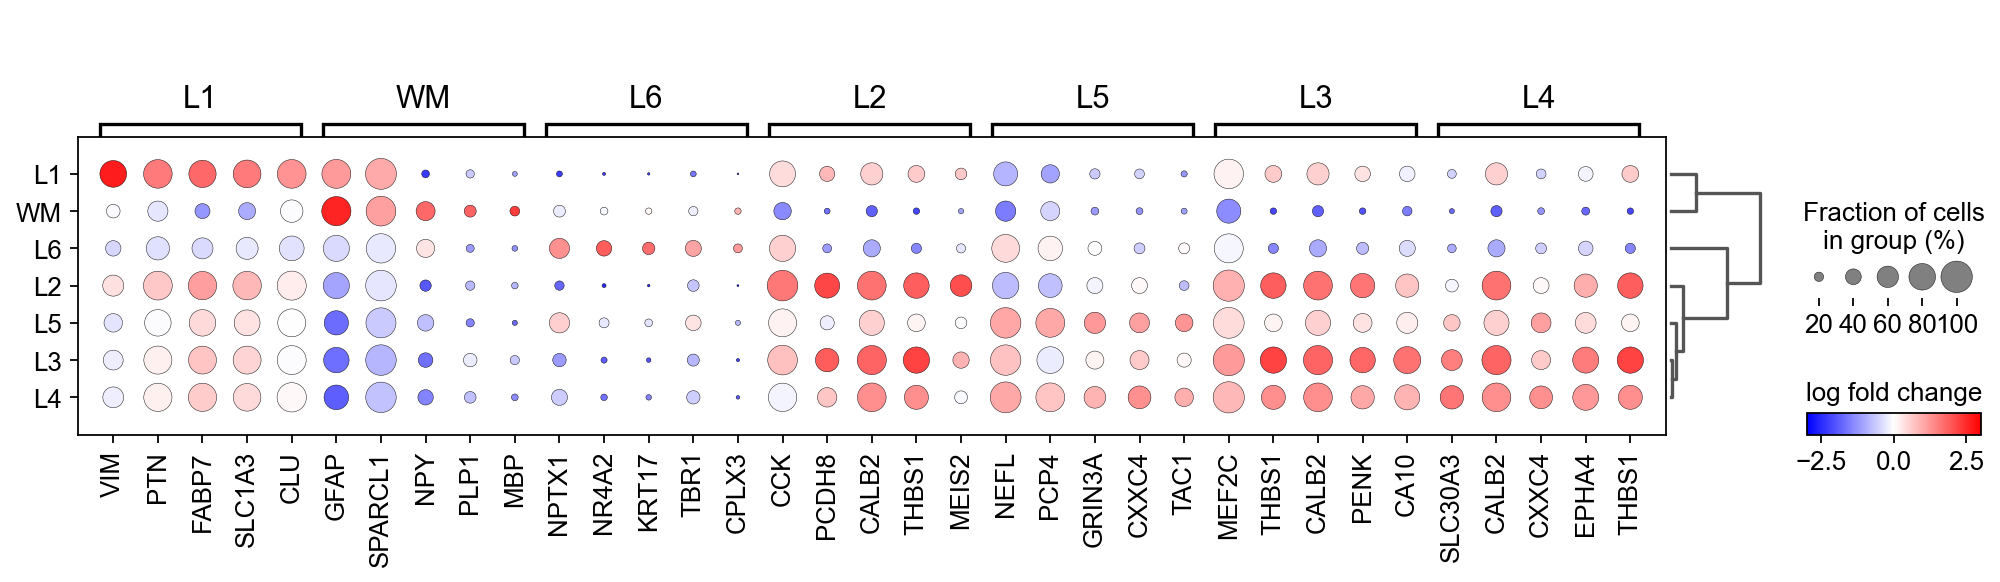

In [11]:
sc.pl.rank_genes_groups_dotplot(chimp_labeled_nonempty, n_genes=5, groupby="clusters", values_to_plot='logfoldchanges',
                                min_logfoldchange=1, vmax=3, vmin=-3, cmap='bwr')

C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


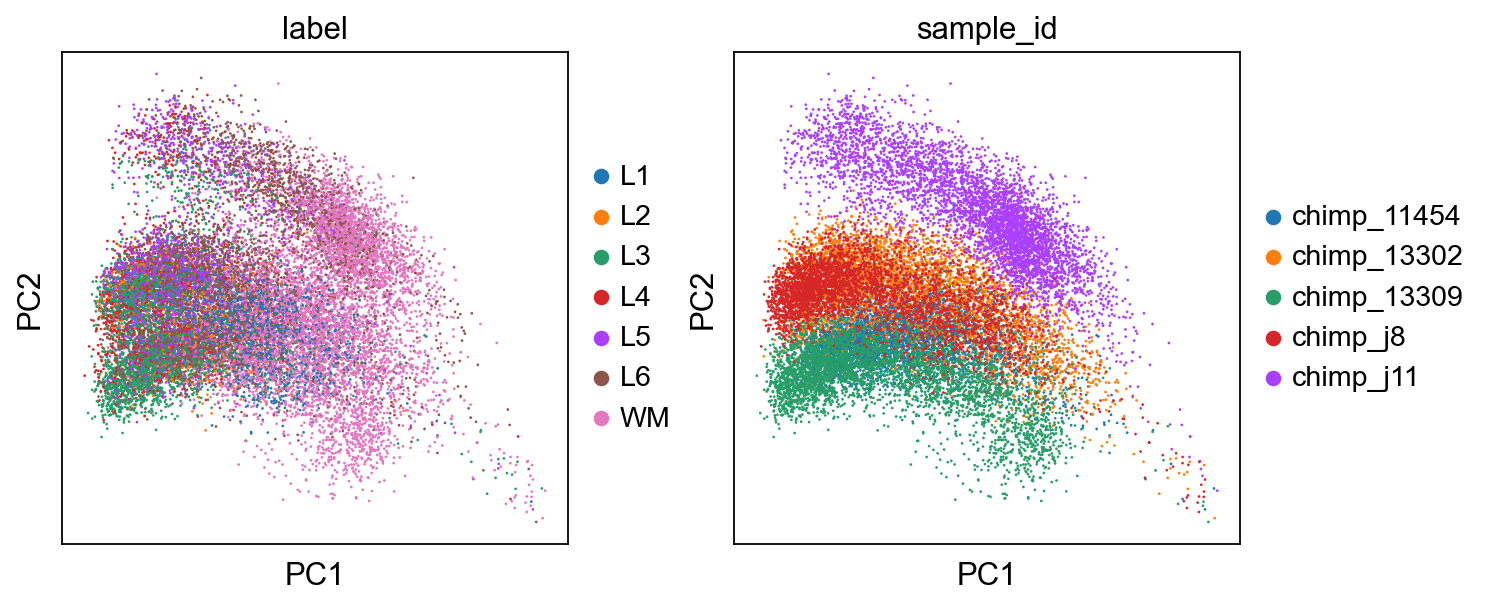

In [12]:
sc.pl.pca(chimp_labeled_nonempty, color=['label', 'sample_id'])

## Macaque

In [51]:
macaque_labeled_nonempty = macaque[(macaque.obs.label.notna()) & (macaque.obs.label != 'Empty spots')].copy()

In [52]:
sc.pp.normalize_total(macaque_labeled_nonempty, target_sum=1e4)
sc.pp.log1p(macaque_labeled_nonempty)

normalizing counts per cell
    finished (0:00:00)


In [53]:
macaque_labeled_nonempty.obs['clusters'] = macaque_labeled_nonempty.obs.label
macaque_labeled_nonempty.obs.clusters.replace({'L6a': 'L6', 'L6b': 'L6', '6a': 'L6'}, inplace=True)

In [54]:
sc.tl.rank_genes_groups(macaque_labeled_nonempty, groupby='clusters', method='wilcoxon')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:57)


         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:01:37)
Storing dendrogram info using `.uns['dendrogram_clusters']`


C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


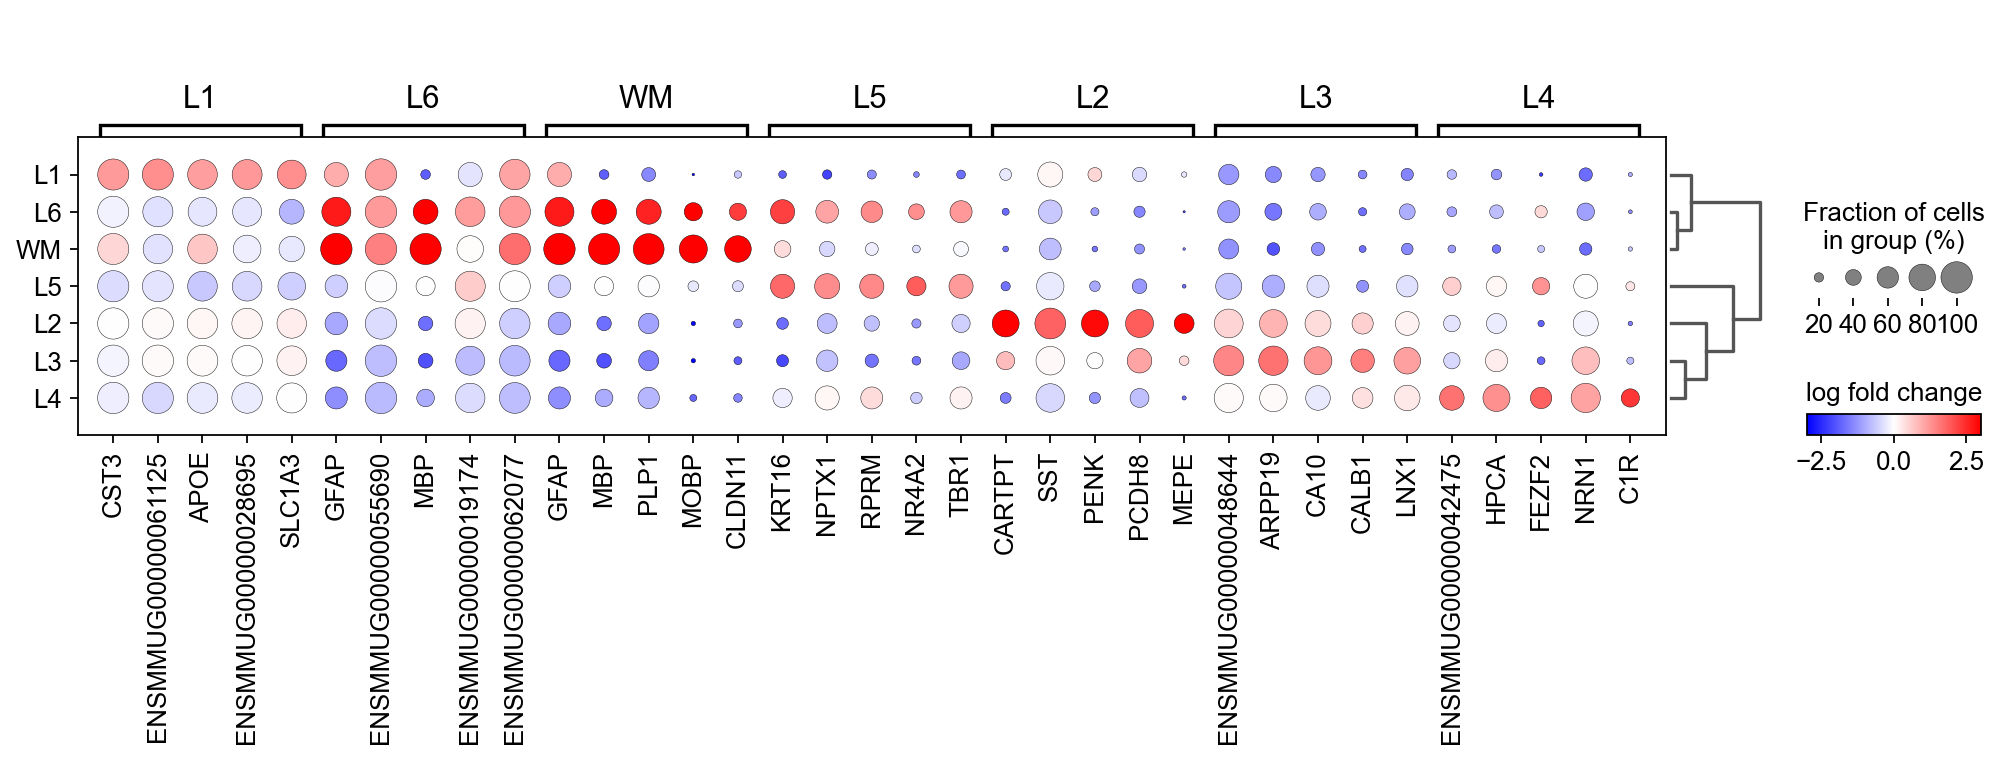

In [55]:
sc.pl.rank_genes_groups_dotplot(macaque_labeled_nonempty, n_genes=5, groupby="clusters", values_to_plot='logfoldchanges',
                                min_logfoldchange=1, vmax=3, vmin=-3, cmap='bwr')

C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


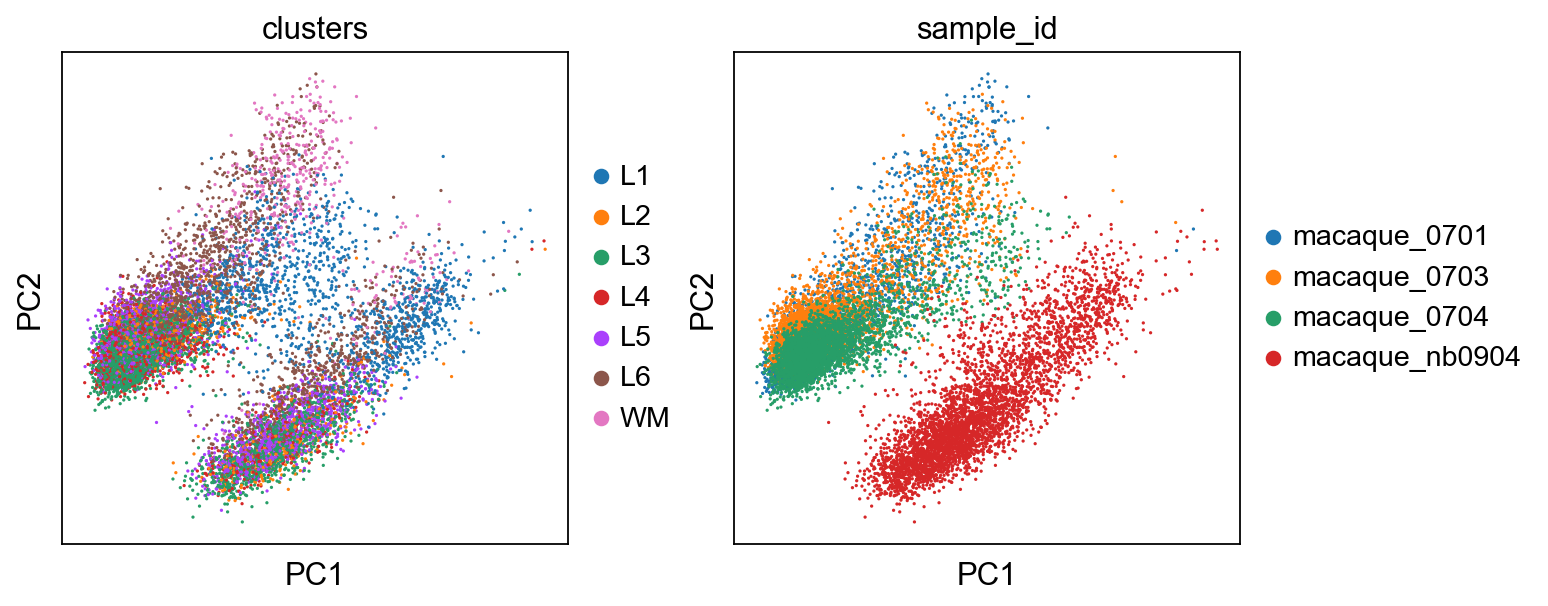

In [56]:
sc.pl.pca(macaque_labeled_nonempty, color=['clusters', 'sample_id'])

# PCA

In [52]:
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)

C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\preprocessing\_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:13)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [53]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:09)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:54)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:42)


In [54]:
adata.obs

,in_tissue,array_row,array_col,label,sample_id
AAACAATCTACTAGCA-1,1,3,43,WM,human_759
AAACACCAATAACTGC-1,1,59,19,L5,human_759
AAACAGAGCGACTCCT-1,1,14,94,Empty spots,human_759
AAACAGTGTTCCTGGG-1,1,73,43,WM,human_759
AAACATTTCCCGGATT-1,1,61,97,L1,human_759
...,...,...,...,...,...
TTGTAAGGCCAGTTGG-1-4,1,27,81,Empty spots,chimp_j8
TTGTATCACACAGAAT-1-4,1,12,74,Empty spots,chimp_j8
TTGTCTCGGCAAGATG-1-4,1,75,41,Empty spots,chimp_j8
TTGTGAACCTAATCCG-1-4,1,56,90,Empty spots,chimp_j8


C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


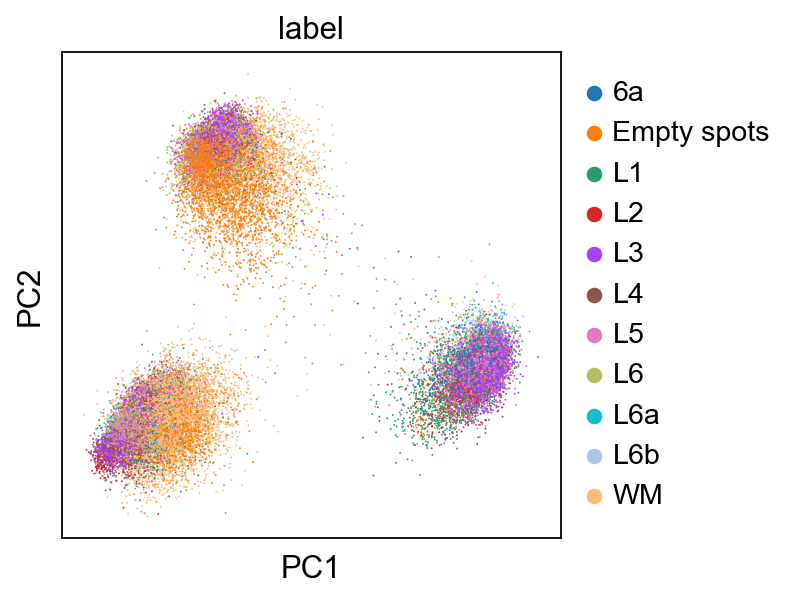

In [58]:
sc.pl.pca(adata, color='label')

In [ ]:
sc.pl.umap(adata, color='label')